In [1]:
# !pip uninstall tensorflow
# !pip install tensorflow==1.15

In [2]:
import tensorflow as tf
tf.__version__

'1.15.0'

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Please use `layer.__call__` method instead.
epoch: 10000, train_error(A): 0.0403452105820179, test_error(B): 0.06682813167572021, B-A: 0.026482921093702316
1 / 360 done
epoch: 10000, train_erro

<function matplotlib.pyplot.colorbar>

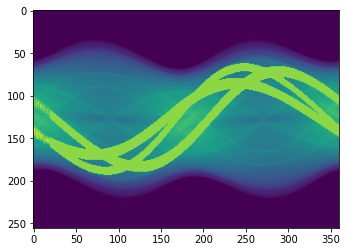

In [4]:
def min_max_scaling(x):
    x_np = np.array(x)
    return (x_np - x_np.mean()) / (x_np.max() - x_np.min() + 1e-7)

def reverse_min_max_scaling(org_x, x):
    org_x_np = np.asarray(org_x)
    x_np = np.asarray(x)
    return(x_np * (org_x_np.max()- org_x_np.min() + 1e-7)) + org_x_np.min()

f = open("sino0.txt", 'r')
line = f.read()
f.close

import numpy as np
import matplotlib.pyplot as plt
metal0_img = np.zeros((256,360))
k = 0
l = 0
for i, j in enumerate(line):
    if j == '\t':
        metal0_img[k,l] = float(line[i-14:i])
        k = k+1
        if k == 256:
            k = 0
            l = l+1
norm_metal0_img = metal0_img
metal0_img = min_max_scaling(metal0_img)

f = open("tooth3-3.txt", 'r')
line = f.read()
f.close
metal3_img = np.zeros((256,360))
k = 0
l = 0
for i, j in enumerate(line):
    if j == '\t':
        metal3_img[k,l] = float(line[i-14:i])
        k = k+1
        if k == 256:
            k = 0
            l = l+1
norm_metal3_img = metal3_img
metal3_img = min_max_scaling(metal3_img)

import tensorflow as tf

def lstm_cell():
    cell = tf.contrib.rnn.BasicLSTMCell(num_units = 20, forget_bias = 1.0, state_is_tuple = True, activation = tf.nn.softsign)

    if keep_prob < 1.0:
        cell = tf.contrib.rnn.DropoutWrapper(cell, output_keep_prob = keep_prob)
    return cell

# a의 범위 0 < a < 360

for a in range(20):
    tf.reset_default_graph()
    
    dataX = []
    dataY = []

    length = 40

    for i in range(256-length):
        dataX.append([metal0_img[i:i+length, a]])
        dataY.append([metal0_img[i+length, a]])

    train_size = int(len(dataY)*0.8)
    test_size = int(len(dataY) - train_size)

    trainX = np.array(dataX[0:train_size])
    trainY = np.array(dataY[0:train_size])

    testX = np.array(dataX[train_size:])
    testY = np.array(dataY[train_size:])

    X = tf.placeholder(tf.float32, [None, 1, length])
    Y = tf.placeholder(tf.float32, [None, 1])

    targets = tf.placeholder(tf.float32, [None, 1])

    predictions = tf.placeholder(tf.float32, [None, 1])

    keep_prob = 0.8
    num_stacked_layers = 1
    learning_rate = 0.01


    stackedRNNs = [lstm_cell() for _ in range(num_stacked_layers)]
    multi_cells = tf.contrib.rnn.MultiRNNCell(stackedRNNs, state_is_tuple = True) if num_stacked_layers > 1 else lstm_cell()

    hypothesis, _states = tf.nn.dynamic_rnn(multi_cells, X, dtype= tf.float32)

    hypothesis = tf.contrib.layers.fully_connected(hypothesis[:, -1], 1, activation_fn = tf.identity)

    loss = tf.reduce_sum(tf.square(hypothesis - Y))

    optimizer = tf.train.AdamOptimizer(learning_rate)

    train = optimizer.minimize(loss)

    rmse = tf.sqrt(tf.reduce_mean(tf.squared_difference(targets, predictions)))

    train_error_summary = []
    test_error_summary = []
    test_predict = ''

    sess = tf.Session()
    sess.run(tf.global_variables_initializer())

    epoch_num = 10000

    for epoch in range(epoch_num):
        _, _loss = sess.run([train, loss], feed_dict = {X: trainX, Y: trainY})
        if ((epoch + 1)% 100 == 0) or (epoch == epoch_num-1):
            train_predict = sess.run(hypothesis, feed_dict = {X:trainX})
            train_error = sess.run(rmse, feed_dict = {targets: trainY, predictions: train_predict})
            train_error_summary.append(train_error)

            test_predict = sess.run(hypothesis, feed_dict= {X: testX})
            test_error = sess.run(rmse, feed_dict = {targets: testY, predictions: test_predict})
            test_error_summary.append(test_error)

    print("epoch: {}, train_error(A): {}, test_error(B): {}, B-A: {}".format(epoch+1, train_error, test_error, test_error-train_error))

    metal3_predictX = []
    metal3_predictY = []

    metal3_max = metal3_img[:,a].max()

    for i, j in zip(metal3_img[:,a],range(256)):
        if i == metal3_max:
            metal3_predictX = np.array([[metal3_img[j-length:j,a]]])
            metal3_img[j,a] = sess.run(hypothesis, feed_dict = {X: metal3_predictX})
    print(a+1,'/ 360 done')
plt.imshow(metal3_img[:])
plt.colorbar
# metal3_img = revers_min_max_scaling(norm_metal3_img, metal3_img)

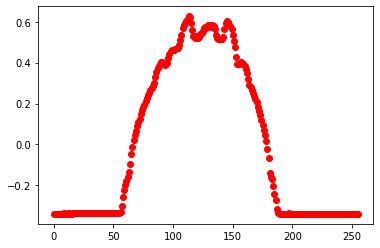

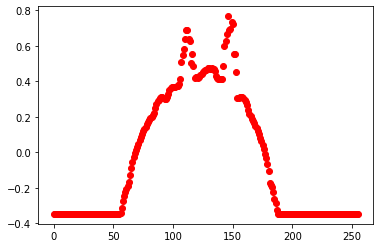

In [5]:
plt.figure(1)
x = range(0,256)
y = [metal0_img[v,8] for v in x]
plt.plot(x, y, 'ro')
plt.figure(2)
x = range(0,256)
y = [metal3_img[v,8] for v in x]
plt.plot(x, y, 'ro')